<a href="https://colab.research.google.com/github/vesc0/transactions-analysis/blob/main/financial_transactions_fraud_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fraud Detection in Financial Transactions

1. Introduction and EDA

In [1]:
# Import the necesarry libraries
# Core libraries
import numpy as np
import pandas as pd
# Visualization
import matplotlib.pyplot as plt
# Google Drive
from google.colab import drive

drive.mount('/content/drive')

dataset = pd.read_csv('/content/drive/MyDrive/fraud_data/Fraud.csv')
dataset.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


This dataset contains simulated financial transaction records, representing customer activity over a period of 30 days, where each time step corresponds to one hour. The dataset includes transaction details such as transaction type, amount, origin and destination accounts, and account balances before and after each transaction.

In [2]:
# Summary of the dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [3]:
# Detect class imbalance
fraud_stats = pd.DataFrame({
    'count': dataset['isFraud'].value_counts(),
    'percentage (%)': (dataset['isFraud'].value_counts(normalize=True) * 100).round(3)
})
fraud_stats

,count,percentage (%)
isFraud,,
0,6354407,99.871
1,8213,0.129


A small fraction of transactions are labeled as fraudulent (isFraud = 1), representing behavior where fraudulent agents attempt to transfer funds and subsequently cash them out. The dataset is highly imbalanced, with fraudulent transactions accounting for approximately 0.13% of all observations, which reflects real-world fraud detection challenges.

In [4]:
# Check if there are missing data fields in the dataset
missing_data = dataset.isnull().sum()
columns_with_missing_data = missing_data[missing_data > 0]

# Show result
if not columns_with_missing_data.empty:
    print("Columns with missing data:")
    print(columns_with_missing_data)
else:
    print("No missing data found in the dataset.")

No missing data found in the dataset.


In [5]:
# Check fraud probability in each transaction type
dataset.groupby('type')['isFraud'].mean().sort_values(ascending=False)

,isFraud
type,
TRANSFER,0.007688
CASH_OUT,0.001840
CASH_IN,0.000000
DEBIT,0.000000
PAYMENT,0.000000


An analysis of conditional fraud probabilities by transaction type shows that fraudulent activity occurs exclusively in TRANSFER and CASH_OUT transactions. No fraudulent cases are observed in PAYMENT, DEBIT, or CASH_IN transactions. This aligns with the dataset description, where fraudulent agents attempt to transfer funds and subsequently cash them out, confirming that transaction type is a strong indicator of fraudulent behavior.

In [6]:
# Compare fraudulent vs non-fraudulent transactions by amount (distribution)
dataset.groupby('isFraud')['amount'].describe()

,count,mean,std,min,25%,50%,75%,max
isFraud,,,,,,,,
0,6354407.0,1.781970e+05,5.962370e+05,0.01,13368.395,74684.72,208364.76,92445516.64
1,8213.0,1.467967e+06,2.404253e+06,0.00,127091.330,441423.44,1517771.48,10000000.00


A comparison of transaction amount distributions reveals substantial differences between fraudulent and non-fraudulent transactions. Fraudulent transactions have significantly higher mean and median values, with the median fraud amount being approximately six times larger than that of legitimate transactions. However, the presence of very large non-fraudulent transactions indicates an overlap between the two distributions, implying that transaction amount alone is insufficient for perfect fraud detection.

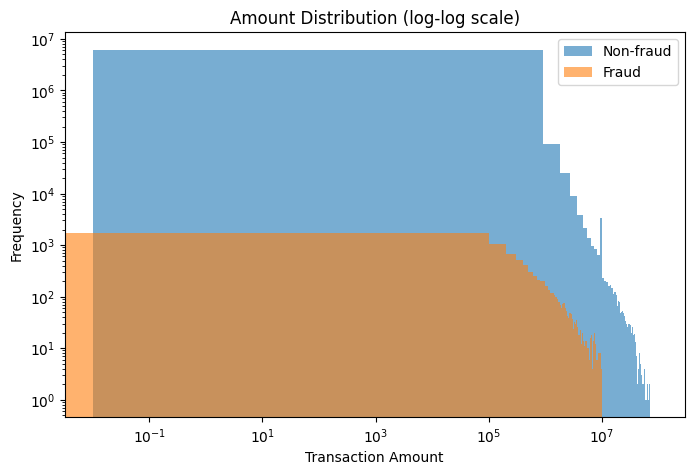

In [7]:
# Visualization
plt.figure(figsize=(8,5))
plt.hist(
    dataset.loc[dataset['isFraud'] == 0, 'amount'],
    bins=100, alpha=0.6, label='Non-fraud'
)
plt.hist(
    dataset.loc[dataset['isFraud'] == 1, 'amount'],
    bins=100, alpha=0.6, label='Fraud'
)
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.title('Amount Distribution (log-log scale)')
plt.show()

The overlaid histograms of transaction amounts, plotted on a log–log scale, reveal highly skewed distributions for both fraudulent and non-fraudulent transactions. While fraudulent transactions tend to involve larger amounts on average, there is substantial overlap between the two distributions, particularly at lower transaction values. Additionally, the dominance of non-fraud transactions across all amount ranges reflects the strong class imbalance present in the dataset rather than an absence of fraud at high values. These findings indicate that transaction amount alone cannot reliably distinguish fraudulent behavior and must be considered in combination with other features.

In [8]:
# Relationship between type and amount for fraud
dataset[dataset['isFraud'] == 1].groupby('type')['amount'].describe()

,count,mean,std,min,25%,50%,75%,max
type,,,,,,,,
CASH_OUT,4116.0,1.455103e+06,2.393842e+06,0.0,125464.45,435516.905,1500761.03,10000000.0
TRANSFER,4097.0,1.480892e+06,2.414890e+06,63.8,128417.96,445705.760,1534985.07,10000000.0


A comparison of fraudulent transaction amounts by transaction type shows that CASH_OUT and TRANSFER fraud cases have nearly identical distributions in terms of mean, median, and dispersion. This suggests that fraudulent behavior follows a consistent monetary pattern regardless of the specific transaction type. Combined with the near-equal frequency of these two fraud categories, the results support the dataset’s underlying fraud scenario in which funds are transferred and subsequently cashed out.

2. Data Preparation & Feature Engineering

In [9]:
# Feature engineering - derive informative features
dataset['hour'] = dataset['step'] % 24
dataset['deltaOrig'] = dataset['oldbalanceOrg'] - dataset['oldbalanceDest']
dataset['balanceErrorOrig'] = dataset['newbalanceOrig'] + dataset['amount'] - dataset['oldbalanceOrg']
dataset['balanceErrorDest'] = dataset['oldbalanceDest'] + dataset['amount'] - dataset['newbalanceDest']

# Features to keep (raw + derived)
features = ['step', 'type', 'amount', 'oldbalanceOrg', 'oldbalanceDest',
            'hour', 'deltaOrig', 'balanceErrorOrig', 'balanceErrorDest']

# Target variable
target = 'isFraud'

# Separate features (X) and target (y)
X = dataset[features].copy()
y = dataset[target].copy()

# Check the first few rows
X.head()

,step,type,amount,oldbalanceOrg,oldbalanceDest,hour,deltaOrig,balanceErrorOrig,balanceErrorDest
0,1,PAYMENT,9839.64,170136.0,0.0,1,170136.0,0.0,9839.64
1,1,PAYMENT,1864.28,21249.0,0.0,1,21249.0,0.0,1864.28
2,1,TRANSFER,181.00,181.0,0.0,1,181.0,0.0,181.00
3,1,CASH_OUT,181.00,181.0,21182.0,1,-21001.0,0.0,21363.00
4,1,PAYMENT,11668.14,41554.0,0.0,1,41554.0,0.0,11668.14


In [10]:
# Build preprocessing pipeline (handles encoding + scaling automatically)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Define feature types
num_features = ['step', 'amount', 'oldbalanceOrg', 'oldbalanceDest',
                'hour', 'deltaOrig', 'balanceErrorOrig', 'balanceErrorDest']
cat_features = ['type']

# Preprocessing: scale numeric, one-hot encode categorical
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
])

3. Splitting data into training and validation sets

In [11]:
# Check how imbalanced the target is
y.value_counts(normalize=True)

,proportion
isFraud,
0,0.998709
1,0.001291


In [12]:
# Import train/test split
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # maintain fraud ratio
)

# Check sizes
print("Training samples:", X_train.shape[0])
print("Validation samples:", X_valid.shape[0])

Training samples: 5090096
Validation samples: 1272524


4. Model Training & Hyperparameter Tuning

Each model is tuned via `RandomizedSearchCV` with stratified 3-fold cross-validation, scored by PR-AUC (`average_precision`), which is more informative than ROC-AUC for highly imbalanced data. A 5% subsample (~250K rows) of training data is used for tuning speed. The best estimator is then evaluated on the held-out validation set.

4.1. Logistic Regression

In [13]:
# Shared tuning setup
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Subsample training data for faster tuning (5% ≈ 250K rows — sufficient for tuning)
X_tune, _, y_tune, _ = train_test_split(
    X_train, y_train, train_size=0.05, random_state=42, stratify=y_train
)
print(f"Tuning on {X_tune.shape[0]:,} samples with {y_tune.sum():,} fraud cases")

Tuning on 254,504 samples with 328 fraud cases


In [14]:
# Logistic Regression with hyperparameter tuning
from sklearn.linear_model import LogisticRegression

log_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(solver='saga', max_iter=1000, random_state=42))
])

log_params = {
    'model__C': [0.01, 0.1, 1, 10],
    'model__penalty': ['l1', 'l2'],
    'model__class_weight': ['balanced', {1: 50}, {1: 100}],
}

log_search = RandomizedSearchCV(
    log_pipeline, log_params, n_iter=15, cv=cv,
    scoring='average_precision', random_state=42, n_jobs=-1, verbose=1
)
log_search.fit(X_tune, y_tune)

print(f"\nBest CV PR-AUC: {log_search.best_score_:.4f}")
print(f"Best params: {log_search.best_params_}")

# Evaluate on validation set
log_best = log_search.best_estimator_
y_pred_log = log_best.predict(X_valid)
print("\nValidation Set:")
print(confusion_matrix(y_valid, y_pred_log))
print(classification_report(y_valid, y_pred_log))

Fitting 3 folds for each of 15 candidates, totalling 45 fits


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



Best CV PR-AUC: 0.6663
Best params: {'model__penalty': 'l1', 'model__class_weight': {1: 100}, 'model__C': 1}

Validation Set:
[[1262246    8635]
 [    219    1424]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1270881
           1       0.14      0.87      0.24      1643

    accuracy                           0.99   1272524
   macro avg       0.57      0.93      0.62   1272524
weighted avg       1.00      0.99      1.00   1272524



After tuning, Logistic Regression achieves high recall (≈0.87) but very low precision (≈0.14), meaning it catches most fraud cases at the cost of many false positives. The best configuration uses l1 regularization with a strong positive class weight, which helps surface rare fraud cases. This highlights the fundamental limitation of linear models: they cannot capture the non-linear decision boundary needed to cleanly separate fraudulent from legitimate transactions.

4.2. Random Forest

In [15]:
# Random Forest with hyperparameter tuning
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=42))  # no n_jobs here, let CV handle parallelism
])

rf_params = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [10, 20, 30],  # avoid None (unlimited depth is very slow)
    'model__min_samples_split': [2, 5, 10],
    'model__class_weight': ['balanced', 'balanced_subsample'],
}

rf_search = RandomizedSearchCV(
    rf_pipeline, rf_params, n_iter=15, cv=cv,
    scoring='average_precision', random_state=42, n_jobs=-1, verbose=1
)
rf_search.fit(X_tune, y_tune)

print(f"\nBest CV PR-AUC: {rf_search.best_score_:.4f}")
print(f"Best params: {rf_search.best_params_}")

# Evaluate on validation set
rf_best = rf_search.best_estimator_
y_pred_rf = rf_best.predict(X_valid)
print("\nValidation Set:")
print(confusion_matrix(y_valid, y_pred_rf))
print(classification_report(y_valid, y_pred_rf))

Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best CV PR-AUC: 0.9023
Best params: {'model__n_estimators': 200, 'model__min_samples_split': 10, 'model__max_depth': 30, 'model__class_weight': 'balanced'}

Validation Set:
[[1270855      26]
 [    411    1232]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.98      0.75      0.85      1643

    accuracy                           1.00   1272524
   macro avg       0.99      0.87      0.92   1272524
weighted avg       1.00      1.00      1.00   1272524



After tuning, Random Forest achieves very high precision (≈0.98) with moderate recall (≈0.75). The best configuration uses 200 trees with max depth 30 and balanced class weights. Almost every flagged transaction is genuinely fraudulent, though roughly 1 in 4 fraud cases are missed. This precision-recall tradeoff makes it well-suited for scenarios where false alarms are costly.

4.3. XGBoost

In [16]:
# XGBoost with hyperparameter tuning
from xgboost import XGBClassifier

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBClassifier(eval_metric='logloss', random_state=42))
])

xgb_params = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__scale_pos_weight': [50, 77, 100, 200],
    'model__subsample': [0.7, 0.8, 1.0],
    'model__colsample_bytree': [0.7, 0.8, 1.0],
}

xgb_search = RandomizedSearchCV(
    xgb_pipeline, xgb_params, n_iter=20, cv=cv,
    scoring='average_precision', random_state=42, n_jobs=-1, verbose=1
)
xgb_search.fit(X_tune, y_tune)

print(f"\nBest CV PR-AUC: {xgb_search.best_score_:.4f}")
print(f"Best params: {xgb_search.best_params_}")

# Evaluate on validation set
xgb_best = xgb_search.best_estimator_
y_pred_xgb = xgb_best.predict(X_valid)
print("\nValidation Set:")
print(confusion_matrix(y_valid, y_pred_xgb))
print(classification_report(y_valid, y_pred_xgb))

Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best CV PR-AUC: 0.9323
Best params: {'model__subsample': 0.8, 'model__scale_pos_weight': 50, 'model__n_estimators': 200, 'model__max_depth': 5, 'model__learning_rate': 0.1, 'model__colsample_bytree': 0.7}

Validation Set:
[[1270718     163]
 [    237    1406]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.90      0.86      0.88      1643

    accuracy                           1.00   1272524
   macro avg       0.95      0.93      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524




After tuning, XGBoost achieves the best overall balance with precision ≈0.90 and recall ≈0.86 (PR-AUC: 0.9323). The optimal configuration uses `scale_pos_weight=50`, `max_depth=5`, and `subsample=0.8`. Compared to Random Forest, it trades a small drop in precision for a notable gain in recall — catching more fraud cases while still keeping false positives low. This makes it the strongest model for this task.

5. Model Comparison

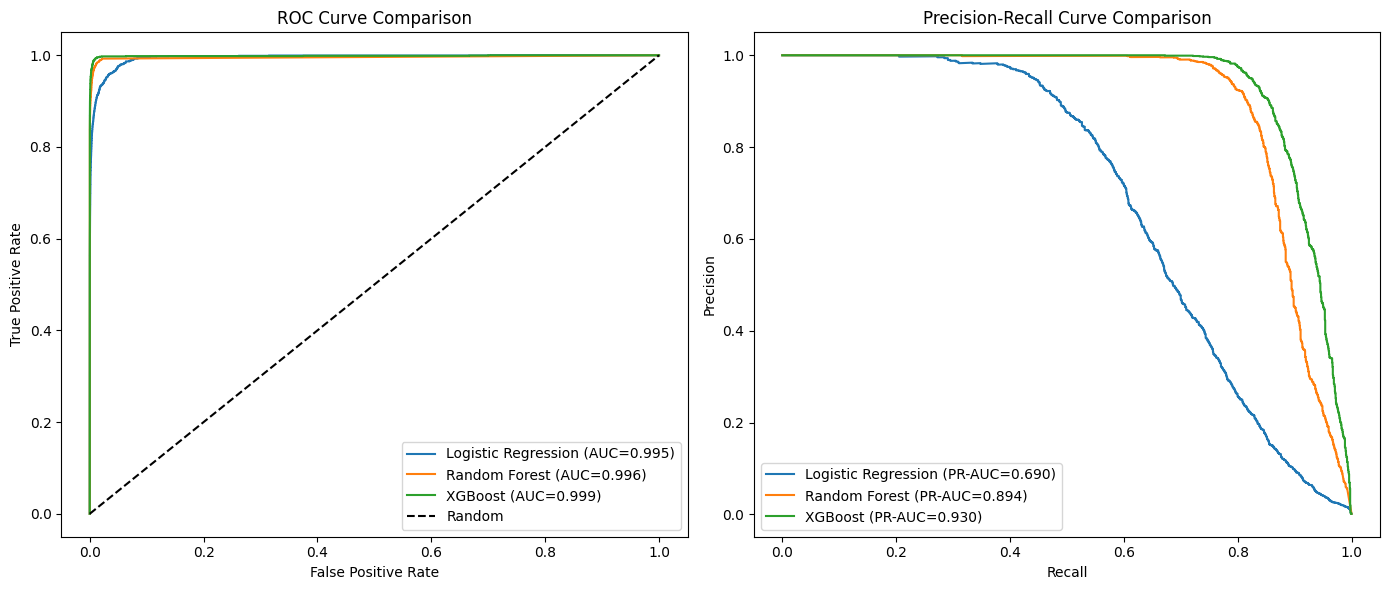


Model                        ROC-AUC     PR-AUC
-----------------------------------------------
Logistic Regression           0.9948     0.6899
Random Forest                 0.9957     0.8936
XGBoost                       0.9986     0.9304


In [17]:
# Model comparison: ROC-AUC and PR-AUC (using best tuned estimators)
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve

# Predict probabilities with tuned models
y_prob_log = log_best.predict_proba(X_valid)[:, 1]
y_prob_rf  = rf_best.predict_proba(X_valid)[:, 1]
y_prob_xgb = xgb_best.predict_proba(X_valid)[:, 1]

# Scores
auc_log, pr_auc_log = roc_auc_score(y_valid, y_prob_log), average_precision_score(y_valid, y_prob_log)
auc_rf, pr_auc_rf   = roc_auc_score(y_valid, y_prob_rf),  average_precision_score(y_valid, y_prob_rf)
auc_xgb, pr_auc_xgb = roc_auc_score(y_valid, y_prob_xgb), average_precision_score(y_valid, y_prob_xgb)

# Curves
fpr_log, tpr_log, _ = roc_curve(y_valid, y_prob_log)
fpr_rf, tpr_rf, _   = roc_curve(y_valid, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_valid, y_prob_xgb)

prec_log, rec_log, _ = precision_recall_curve(y_valid, y_prob_log)
prec_rf, rec_rf, _   = precision_recall_curve(y_valid, y_prob_rf)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_valid, y_prob_xgb)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC={auc_log:.3f})')
ax1.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf:.3f})')
ax1.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={auc_xgb:.3f})')
ax1.plot([0,1], [0,1], 'k--', label='Random')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve Comparison')
ax1.legend()

ax2.plot(rec_log, prec_log, label=f'Logistic Regression (PR-AUC={pr_auc_log:.3f})')
ax2.plot(rec_rf, prec_rf, label=f'Random Forest (PR-AUC={pr_auc_rf:.3f})')
ax2.plot(rec_xgb, prec_xgb, label=f'XGBoost (PR-AUC={pr_auc_xgb:.3f})')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve Comparison')
ax2.legend()

plt.tight_layout()
plt.show()

# Summary table
print(f"\n{'Model':<25} {'ROC-AUC':>10} {'PR-AUC':>10}")
print("-" * 47)
print(f"{'Logistic Regression':<25} {auc_log:>10.4f} {pr_auc_log:>10.4f}")
print(f"{'Random Forest':<25} {auc_rf:>10.4f} {pr_auc_rf:>10.4f}")
print(f"{'XGBoost':<25} {auc_xgb:>10.4f} {pr_auc_xgb:>10.4f}")

6. Conclusion

This project demonstrates a complete fraud detection pipeline on a highly imbalanced dataset (~0.13% fraud rate). Key findings:

- **Feature engineering** (balance error features, hour of day) significantly improves model signal beyond raw transaction fields.

- **Hyperparameter tuning via RandomizedSearchCV** with PR-AUC scoring meaningfully improved all models, particularly XGBoost's precision (from ≈0.31 to ≈0.90).In practice, the choice between models depends on the cost asymmetry between missing fraud (false negative) and incorrectly flagging legitimate transactions (false positive). XGBoost is recommended as the primary model, with threshold adjustment available to further tune the precision-recall tradeoff.

- **XGBoost** is the best overall model (PR-AUC: 0.9304, ROC-AUC: 0.9986), offering the strongest precision-recall balance after tuning.

- **Random Forest** is the most conservative choice (precision ≈0.98), ideal when false positives carry a high cost.

- **Logistic Regression** is a reasonable high-recall baseline but cannot match non-linear models on this task.